<a href="https://colab.research.google.com/github/Jiaying-Yao/COMP551-ML/blob/main/Dropout_CNN_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
import sys
#sys.path.append('/content/gdrive/hipsternet-master')

Mounted at /content/drive


In [2]:
sys.path.insert(0,'/content/drive/My Drive/hipsternet-master')

In [3]:
import hipsternet

In [4]:
import numpy as np
import hipsternet.input_data as input_data
import hipsternet.neuralnet as nn
from hipsternet.solver import *

In [5]:
import tensorflow as tf
import sympy
import numpy as np
import seaborn as sns
import collections
import torch
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from __future__ import print_function

np.random.seed(123)

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt

In [6]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


Before rotating 15%


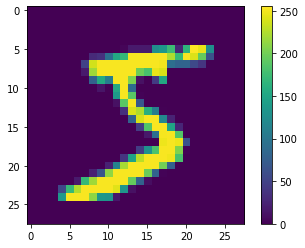

After rotating 15%


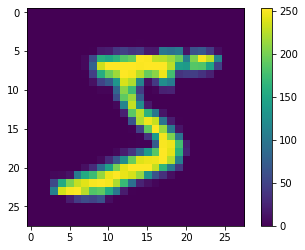

In [7]:
import tensorflow_datasets as tfds 
from keras.preprocessing.image import ImageDataGenerator

#Generating rotated images: rotated 15%, fill empty pixal with closest color
datagen = ImageDataGenerator(rotation_range=15,horizontal_flip=False,fill_mode='nearest')
datagen.fit(x_train.reshape(x_train.shape[0],28,28,1))

#Print the first rotated image
print('Before rotating 15%')
plt.imshow(x_train[0])
plt.colorbar()
plt.show()

print('After rotating 15%')
for X, Y in datagen.flow(x_train.reshape(x_train.shape[0], 28, 28, 1),y_train.reshape(y_train.shape[0], 1),batch_size=32,shuffle=False):
        plt.imshow(X[0].reshape(28,28))
        plt.colorbar()
        plt.show()
        break

#append new images to training set: image size should be at least 3D, so reshape is necessary here
i=0
x_train_aug = x_train
y_train_aug = y_train
for X, Y in datagen.flow(x_train.reshape(x_train.shape[0], 28, 28, 1),y_train.reshape(y_train.shape[0], 1),batch_size=32,shuffle=False):
        x_train_aug = np.vstack([x_train_aug, X.reshape(X.shape[0],28,28)])
        y_train_aug = np.append(y_train_aug, Y)
        i += 1
        if (i > x_train.shape[0]/32): break #fix here

In [8]:
#Augmented training sets: x_train_aug, y_train_aug
#vectorize data into 2-d np array
x_train, x_test = x_train.reshape(x_train.shape[0], x_train.shape[1]*x_train.shape[2]), x_test.reshape(x_test.shape[0], x_test.shape[1] * x_test.shape[2])

#normalization: rescale the images from [0,255] to the [0.0,1.0] range.
x_train, x_test = x_train/255.0, x_test/255.0
print("Dimansion of x_train: ", x_train.shape)

#reshape and normalize the augmented training set
x_train_aug = x_train_aug.reshape(x_train_aug.shape[0], x_train_aug.shape[1]*x_train_aug.shape[2])
x_train_aug = x_train_aug/255.0
print("Dimansion of x_train_aug: ", x_train_aug.shape)

#take the first 100 as validation set
x_validation = x_train[:100]
y_validation = y_train[:100]
x_train = x_train[101:]
y_train = y_train[101:]

#unormalized data
#x_train_unormalized = x_train * 255.0
#x_test_unormalized = x_test * 255.0
#x_validation_unormalized = x_validation * 255.0

#At this point x_train, x_test, x_train_unormalized, x_validation_unormalized, x_test_unormalized, x_validation are 2-d np array, y_train, y_test, y_validation are 1-d np array

Dimansion of x_train:  (60000, 784)
Dimansion of x_train_aug:  (120032, 784)


In [9]:
# preprocess data, normalization by substracting training mean from training, validation, test datasets
def prepro(X_train, X_val, X_test):
    mean = np.mean(X_train)
    return X_train - mean, X_val - mean, X_test - mean

Hyper-param tuning (Not used)

In [10]:
def tune_hyperparam(model, n_iter, alpha, mb_size, n_experiment, reg, print_after, p_dropout, loss, nonlin, solver_fun, max_norm, x_train, x_val, x_test, y_train, y_val, y_test, candidates, nlayer):
    M, D, C = x_train.shape[0], x_train.shape[1], y_train.max() + 1

    accuracies = np.array([[0,0,0,0]]) # initiate accuracy array, containing hyper-param candidates composition and corresponding accuracy
    accs = np.zeros(n_experiment) # initiate accuracy array for a single set of hyper-param

    for max_norm in candidates[0]:
      for dropout_rate_input in candidates[1]:
        for dropout_rate_hidden in candidates[2]:
          # composite the droup out array based on the number of hidden layers
          dropoutArray = np.array([dropout_rate_input])
          for i in range(1):
            dropoutArray = np.append(dropoutArray, [dropout_rate_hidden])

          print('Experiment on hyper-parm candidates. max_norm: ', max_norm, 'input drop out rate: ', dropout_rate_input, 'hidden layer drop out rate: ', dropout_rate_hidden)

          for k in range(n_experiment):
             print('Experiment-{}'.format(k + 1))

             # Reset model
             if model == 'ff':
                net = nn.FeedForwardNet(D, C, H=2048, lam=reg, p_dropout=dropoutArray, loss=loss, nonlin=nonlin, nlayer=nlayer)
             elif model == 'cnn':
                net = nn.ConvNet(10, C, H=128, lam=1e-3, p_dropout=dropoutArray, loss=loss, nonlin=nonlin)

             net = solver_fun(
                 net, x_train, y_train, val_set=(x_val, y_val), mb_size=mb_size, alpha=alpha,
                 n_iter=n_iter, print_after=print_after, max_norm=max_norm
             )

             y_pred = net.predict(x_test)
             accs[k] = np.mean(y_pred == y_test)

          print()
          print('Mean accuracy: {:.4f}, std: {:.4f}'.format(accs.mean(), accs.std()))
          print()
          
          accuracies = np.concatenate((accuracies, [[max_norm, dropout_rate_input, dropout_rate_hidden, accs.mean()]]))

      
    
    index = np.argmax(accuracies, axis=0)[3] # index of the best hyper-parm in the accuracies
    best_max_norm = accuracies[index][0]
    best_dropout_rate_input = accuracies[index][1]
    best_dropout_rate_hidden = accuracies[index][2]
    best_acc = accuracies[index][3]

         
    return best_max_norm, best_dropout_rate_input, best_dropout_rate_hidden, best_acc



In [13]:
# Train and predict mnist dataset
def run_mnist(model, n_iter, alpha, mb_size, n_experiment, reg, print_after, p_dropout, loss, nonlin, solver, max_norm, x_train, x_val, x_test, y_train, y_val, y_test, candidates, nlayer):
    M, D, C = x_train.shape[0], x_train.shape[1], y_train.max() + 1
  
    x_train, x_val, x_test = prepro(x_train, x_val, x_test)
    
    # A key/value hash table of optimization algorithm, all algorithms use minibatch technique
    solvers = dict(
        sgd=sgd,                # SGD
        momentum=momentum,          # Momentum SGD
        nesterov=nesterov,          # Nesterov Momentum
        adagrad=adagrad,           # Adagrad
        rmsprop=rmsprop,          # RMSprop
        adam=adam             # Adam
    )
    
    solver_fun = solvers[solver]
    
    print()
    print('Experimenting on {}'.format(solver))
    print()
    
    if model == 'cnn':
        img_shape = (1, 28, 28)
        x_train = x_train.reshape(-1, *img_shape)
        x_val = x_val.reshape(-1, *img_shape)
        x_test = x_test.reshape(-1, *img_shape)

    #tune hyper-parameters
    best_max_norm, best_dropout_rate_input, best_dropout_rate_hidden, best_acc = tune_hyperparam(model, 500, alpha, mb_size, n_experiment, reg, print_after, p_dropout, loss, nonlin, solver_fun, max_norm, x_train, x_val, x_test, y_train, y_val, y_test, candidates, nlayer)

    #train and predict
    accs = np.zeros(n_experiment) # initiate accuracy array for a single set of hyper-param
    best_dropoutArray = np.array([best_dropout_rate_input])
    for i in range(1):
        best_dropoutArray = np.append(best_dropoutArray, [best_dropout_rate_hidden])

    for k in range(n_experiment):
        print('Experiment-{}'.format(k + 1))

        # Reset model
        if model == 'ff':
           net = nn.FeedForwardNet(D, C, H=2048, lam=reg, p_dropout=best_dropoutArray, loss=loss, nonlin=nonlin, nlayer=nlayer)
        elif model == 'cnn':
           net = nn.ConvNet(10, C, H=1024, lam=1e-3, p_dropout=best_dropoutArray, loss=loss, nonlin=nonlin)

        net = solver_fun(
            net, x_train, y_train, val_set=(x_val, y_val), mb_size=mb_size, alpha=alpha,
            n_iter=n_iter, print_after=print_after, max_norm=best_max_norm
        )

        y_pred = net.predict(x_test)
        accs[k] = np.mean(y_pred == y_test)

    print()
    print('Best max_norm: ', best_max_norm, 'best dropout rate for input: ', best_dropout_rate_input, 'best dropout rate for hidden layers: ', best_dropout_rate_hidden, 'and result accuracy is: ', accs.mean())



Test

Dropout 3-layer CNN with 1024 hidden units
(Conv layer with stride=1, padding=1; Maxpool; Fully connected with relu) 
+ max-norm constraint 

In [14]:
model = 'cnn'
n_iter = 50000
alpha = 1e-3 #learning rate
mb_size = 64
n_experiment = 1
reg = 1e-5
print_after = 100
p_dropout = [0.5,0.8] #only 0.5 is used since only dropout is applied for the only one fully connected layer
loss = 'cross_ent'
nonlin = 'relu'
solver = 'sgd'
max_norm = 4
nlayer = 3

# Define default candidates
candidates = np.array([[3, 3.5, 4],[0.5, 0.65, 0.7, 0.8],[0.8]]) # first hyper-param as max-norm, second as drop-out rate for input layer, third as drop-out rate for hidden layers

run_mnist(model, n_iter, alpha, mb_size, n_experiment, reg, print_after, p_dropout, loss, nonlin, solver, max_norm, x_train, x_validation, x_test, y_train, y_validation, y_test, candidates, nlayer)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  app.launch_new_instance()



Experimenting on sgd

Experiment on hyper-parm candidates. max_norm:  3 input drop out rate:  0.5 hidden layer drop out rate:  0.8
Experiment-1
Iter-100 loss: 2.2404 validation: 0.460000
Iter-200 loss: 2.1985 validation: 0.610000
Iter-300 loss: 2.1318 validation: 0.650000
Iter-400 loss: 2.1099 validation: 0.730000
Iter-500 loss: 1.9789 validation: 0.730000

Mean accuracy: 0.7056, std: 0.0000

Experiment on hyper-parm candidates. max_norm:  3 input drop out rate:  0.65 hidden layer drop out rate:  0.8
Experiment-1
Iter-100 loss: 2.2592 validation: 0.500000
Iter-200 loss: 2.1815 validation: 0.640000
Iter-300 loss: 2.1350 validation: 0.730000
Iter-400 loss: 2.0410 validation: 0.800000
Iter-500 loss: 1.9353 validation: 0.810000

Mean accuracy: 0.7353, std: 0.0000

Experiment on hyper-parm candidates. max_norm:  3 input drop out rate:  0.7 hidden layer drop out rate:  0.8
Experiment-1
Iter-100 loss: 2.2778 validation: 0.410000
Iter-200 loss: 2.2431 validation: 0.640000
Iter-300 loss: 2.222

Dropout 3-layer CNN with 128 hidden units
(Conv layer with stride=1, padding=1; Maxpool; Fully connected with relu) 
+ max-norm constraint 

In [ ]:
model = 'cnn'
n_iter = 50000
alpha = 1e-3 #learning rate
mb_size = 64
n_experiment = 1
reg = 1e-5
print_after = 100
p_dropout = [0.5,0.8] #only 0.5 is used since only dropout is applied for the only one fully connected layer
loss = 'cross_ent'
nonlin = 'relu'
solver = 'sgd'
max_norm = 4
nlayer = 3

# Define default candidates
candidates = np.array([[3, 3.5, 4],[0.5, 0.65, 0.7, 0.8],[0.8]]) # first hyper-param as max-norm, second as drop-out rate for input layer, third as drop-out rate for hidden layers

run_mnist(model, n_iter, alpha, mb_size, n_experiment, reg, print_after, p_dropout, loss, nonlin, solver, max_norm, x_train, x_validation, x_test, y_train, y_validation, y_test, candidates, nlayer)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  app.launch_new_instance()



Experimenting on sgd

Experiment on hyper-parm candidates. max_norm:  3 input drop out rate:  0.5 hidden layer drop out rate:  0.8
Experiment-1
Iter-100 loss: 2.2335 validation: 0.580000
Iter-200 loss: 2.1804 validation: 0.760000
Iter-300 loss: 2.0854 validation: 0.800000
Iter-400 loss: 1.9814 validation: 0.830000
Iter-500 loss: 1.9085 validation: 0.800000

Mean accuracy: 0.7400, std: 0.0000

Experiment on hyper-parm candidates. max_norm:  3 input drop out rate:  0.65 hidden layer drop out rate:  0.8
Experiment-1
Iter-100 loss: 2.2557 validation: 0.360000
Iter-200 loss: 2.2030 validation: 0.510000
Iter-300 loss: 2.1085 validation: 0.650000
Iter-400 loss: 1.9781 validation: 0.670000
Iter-500 loss: 1.9269 validation: 0.730000

Mean accuracy: 0.6773, std: 0.0000

Experiment on hyper-parm candidates. max_norm:  3 input drop out rate:  0.7 hidden layer drop out rate:  0.8
Experiment-1
Iter-100 loss: 2.2461 validation: 0.330000
Iter-200 loss: 2.1336 validation: 0.520000
Iter-300 loss: 2.039